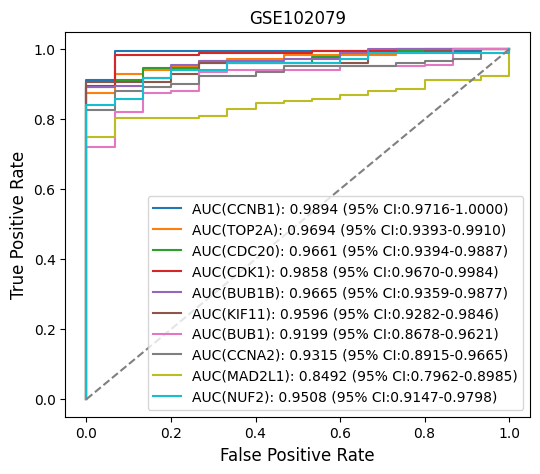

Feature: CCNB1
AUC: 0.9894
95% CI: [0.9716-1.0000]

Feature: TOP2A
AUC: 0.9694
95% CI: [0.9393-0.9910]

Feature: CDC20
AUC: 0.9661
95% CI: [0.9394-0.9887]

Feature: CDK1
AUC: 0.9858
95% CI: [0.9670-0.9984]

Feature: BUB1B
AUC: 0.9665
95% CI: [0.9359-0.9877]

Feature: KIF11
AUC: 0.9596
95% CI: [0.9282-0.9846]

Feature: BUB1
AUC: 0.9199
95% CI: [0.8678-0.9621]

Feature: CCNA2
AUC: 0.9315
95% CI: [0.8915-0.9665]

Feature: MAD2L1
AUC: 0.8492
95% CI: [0.7962-0.8985]

Feature: NUF2
AUC: 0.9508
95% CI: [0.9147-0.9798]



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, model_selection, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut

dataset = pd.read_csv("/kaggle/input/gse112790-hub-genes-logistic-regression/GSE112790_10_hub_genes_logistic_regression.csv")

X = dataset.drop(columns=['Class']).values
y = dataset['Class'].values
feature_names = dataset.columns[:-1] 

scaler = StandardScaler()

# Initialize Logistic Regression model
lrc = linear_model.LogisticRegression(max_iter=10000)

# Create a figure for the ROC curves and CI plots
plt.figure(figsize=(6, 5))

auc_scores = []
ci_values = []

for feature_idx, feature_name in enumerate(feature_names):
    # Select one feature at a time
    feature = X[:, feature_idx].reshape(-1, 1)
    
    # Standardize the feature
    feature = scaler.fit_transform(feature)
    
    # Use LOOCV and compute ROC metrics
    loo = LeaveOneOut()
    scores = model_selection.cross_val_predict(lrc, feature, y, cv=loo, method='decision_function')
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    # Compute AUC ROC score
    roc_auc = metrics.auc(fpr, tpr)
    
    # Calculate 95% CI using bootstrapping
    np.random.seed(0)  # For reproducibility
    n_bootstrap = 1000  # Number of bootstrap samples
    
    auc_bootstrap = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        indices = np.random.choice(len(scores), len(scores), replace=True)
        auc_bootstrap[i] = metrics.roc_auc_score(y[indices], scores[indices])
    
    # Calculate CI
    auc_ci_lower = np.percentile(auc_bootstrap, 2.5)
    auc_ci_upper = np.percentile(auc_bootstrap, 97.5)
    
    # Append AUC score and CI values to lists
    auc_scores.append(roc_auc)
    ci_values.append((auc_ci_lower, auc_ci_upper))
    
    # Plot ROC curve for the current feature
    plt.plot(fpr, tpr, label=f"AUC({feature_name}): {roc_auc:.4f} (95% CI:{auc_ci_lower:.4f}-{auc_ci_upper:.4f})")

# Add a dotted diagonal line representing the random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='')

# Set plot titles and labels
plt.title("GSE102079")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")

# Save the figure
plt.savefig('/kaggle/working/GSE102079_ROC_curve_plot.png')

# Display the ROC curve plot
plt.show()

# Print AUC scores and CI values for each feature
for feature_name, auc, ci in zip(feature_names, auc_scores, ci_values):
    print(f"Feature: {feature_name}\nAUC: {auc:.4f}\n95% CI: [{ci[0]:.4f}-{ci[1]:.4f}]\n")
